# Detailed Workflow of Ripley K Applications to Subsurface Modeling in Python

### The University of Texas at Austin, PGE 2020 SURI, Undergraduation Research
### Alan Scherman, Undergraduate Student, Rice University, UT PGE SURI 2020
### Supervised by:
### Michael Pyrcz, Associate Professor, University of Texas at Austin
***
### Introduction
Ripley's K function is a second moment measure of stationary point patterns (SPP) first formalized by B.D. Ripley in 1976 [[1](https://www.jstor.org/stable/3212829?read-now=1&seq=1#page_scan_tab_contents)]. It is defined as the product of the inverse of an event's intensity ($\lambda$) and the expectation of additional events within a fixed distance ($E[r]$). That is:

<br>
\begin{equation}
K(r) = \frac{E[r]}{\lambda}
\end{equation}

Ripley's K gained importance within spatial point pattern analysis for being a distance-based measure which indicates spatial clustering or dispersion. The user can identify a pattern's spatial tendency by graphically comparing its K function to the K evaluation of complete spatial randomness (CSR) patterns. Within the realm of subsurface modeling, Ripley's K can indicate the spatial distribution of samples with desired properties, such as porosity and permeability, from a known sample.

***
### Theory
The procedure to calculate the $K$ function for a SPP has been illustrated in several formats (see references section for more detail), but it can be synthesized in the following steps:

#### Steps to calculate the Ripley K function of a SPP

1. Determine an area of study $A$ containing a finite number of events $N$;

2. Pick an event from collection of $N$ events possible (e.g. $n_0$) and draw a circle of radius $r$ around it;

3. Count the number of events other than $n_0$ occurring within the circle of radius $r$ AND average this sum by $N$;

4. Repeat steps 2 and 3 for the circles of radius $2r$, $3r$ and so forth until $r$ equals $1/4$ of the smaller side (for rectangular areas by convention);

5. Repeat steps 2 through 4 for all other $N-1$ events within $A$.

Note that for datasets, Step 3 is formalized as a indicator function which returns True (1) for an event within $r$ and False (0) if otherwise. Additionally, there is no rule of thumb for $r_max$ of more complex $A$ geometries. However, it must be stated that the greater $r$, the greater the variance in the SPP and the more biased the $K$ will become.

See below a non-rigorous demonstration of how to calculate the Ripley K function for an event $n_0$ within $A$:

<img src="Ripley_K_Demo.png"/>

The white circles represent the consecutive circles inside which the number of events are counted. The counted events are surrounded by a green ring. Note as well that the events outside $A$ are disregarded (thus the red cross).

#### Edge correction

One pitfall for Ripley's K is the necessity of an edge correction approach for events whose circles exceed the boundaries of $A$. If no edge correction approach is adopted (in which case $K$ is called the *naive estimator*), the $K$ for events closer to the boundaries of $A$ will be biased since it would undercount the number of neighbors for these events (i.e. events outside $A$ are disregarded). The edge correction term is applied by multiplying a weighting term to the expectation for every possible value of $r$. Several edge correction approaches have been proposed, including the border (or guard) zone, Ripley's Isotropic Corrector, and Besag's Edge Correction. Please consult the references section for more detail.

#### Confidence envelopes

However, in order to validate that the clustering or dispersion of a SPP suggested by the $K$ function is relevant, it is necessary to compare it to the $K$ function for a myriad of other CSR patterns. The most common approach is to generate a large number (e.g. 1000 realizations) of Monte Carlo generated CSR patterns and compute the $P10$ and $P90$ of the set of resulting $K$ functions. Graphically speaking, these percentiles provide upper and lower fences which indicate where significant clustering or dispersion begins (i.e. a confidence envelope for typical Poisson distribution behavior). See below an example of a Ripley K graph with confidence envelope:

<img src="Confidence_Env_Demo.png"/>

The Ripley K function is shown in black. The blue line represents the upper fence of the confidence envelope (the $P975$ of 1000 realizations). If the *Ripley K is above the blue line, then there is significant clustering in the SPP*. The red line represents the lower fence of the confidence envelope (the $P25$ of the 1000 realizations). If the *Ripley K is below the red line, then there is significant dispersion (or inhibition) in the SPP*.

#### $L$ and $H$ Transforms

Lastly, it is common to represent the $K$ function by one of its transforms ($L$ and $H$ functions) for better visualization. The transform equations are given below:

<br>
\begin{equation}
L(r) = \sqrt{\frac{K(r)}{\pi}}
\end{equation}
<br>
\begin{equation}
H(r) = \sqrt{\frac{K(r)}{\pi}} - r
\end{equation}

Where $r$ is the search radius and $K(r)$ the Ripley K function.

***
### Objective
For this exercise, we will compute the $K$ function of a subsurface sample with porosity and permeability data. First, we will calculate the regular Ripley K function which will indicate potential clustering or dispersion of our sample events. Then, we will sort our subsurface data for low and high permeability and calculate the cross Ripley K of the transformed data (i.e. we will determine potential clustering or dispersion of low permeability events from high permeability events).

Note that the **_spatstat_** library on **_R_** provides great Ripley K and more distance-based pattern utilities widely used for spatial pattern analysis. Python equivalents can be found under the AstroPy, PySAL, and GeostatsPy packages (which we will utilize in this demonstration).
***
### Load required libraries
In order to find the Ripley K function for our subsurface sample, we will need some Python libraries to help import, manage, and visualize our data. These should be previously installed if you have Anaconda or other similar environment software.

In [1]:
import numpy as np                                      # To manage NumPy arrays
import scipy.stats as sts                               # For use in CSR pattern generation
from pandas import read_csv                             # To import data and obtain summary statistics
from matplotlib import pyplot as plt                    # For plotting
from ripley_k_function import ripley_K                  # Python utility to compute K - more info on later section

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs. 
***
### Visualize data
Let's import our subsurface sample data. For now let us only worry about our events' coordinates. Later, when we do cross Ripley K computations, we will also account for differences in properties (specifically permeability). 

In [2]:
sample1 = read_csv('sample_data_biased_1.csv', usecols = ['X','Y'])
sample1.head()

,X,Y
0,100,900
1,100,800
2,100,600
3,100,500
4,100,100


Since this data set refers to Cartesian coordinates, let us view a scatter plot of the events by their locations:

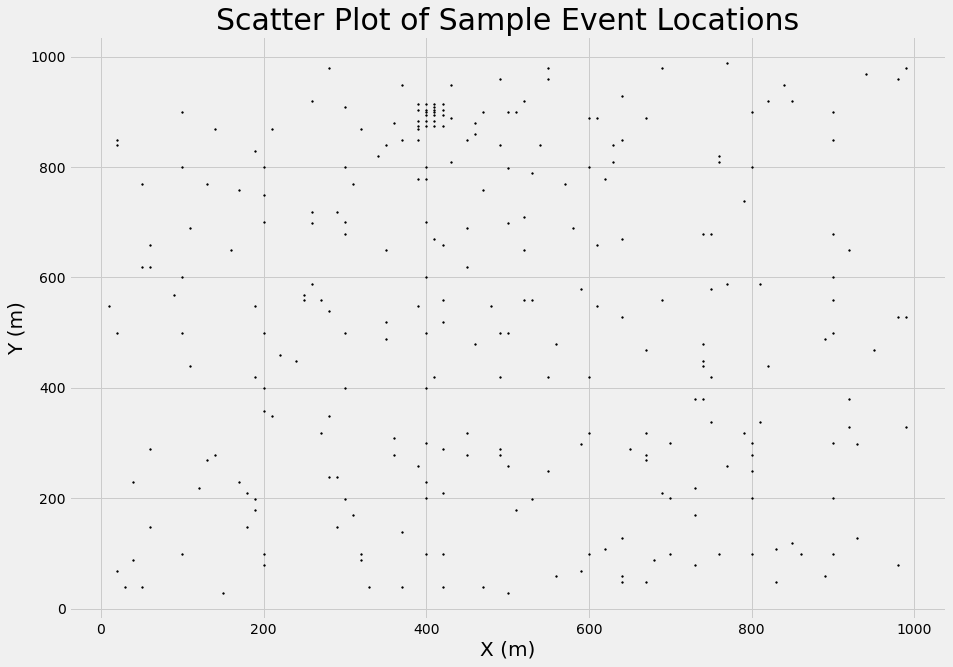

In [3]:
sample1 = sample1.to_numpy()
X = sample1[:,0]; Y = sample1[:,1]
plt.style.use('fivethirtyeight')
figure = plt.figure(figsize=(14,10))
plt.scatter(X,Y,s=3,c='black')
plt.title('Scatter Plot of Sample Event Locations',size=30); plt.xlabel('X (m)',size=20); plt.ylabel('Y (m)',size=20);

At a first glance, we can spot some areas of potential clustering (e.g. at ($x = 400 m$,$y = 900 m$)) and dispersion (e.g. at ($x = 900 m$,$y = 800 m$)). However, we must first apply some SPP distance measure, for instance Ripley's K, to affirm that the SPP above demonstrates significant clustering or dispersion behavior.

***
### Regular Ripley K
In our first analysis, we will calculate the Ripley K function of the entire *sample1* dataset. All events are treated equally, with no distinction due to property values. The resulting curve will indicate potential clustering or dispersion of all events.

#### Determine area of study
Usually, the area of study encompasses the surveyed parts of the subsurface (i.e. all events are mapped within $A$). From the scatter plot produced previously, we can trace a rectangular area of study where $x$ and $y$ each range in $[0 m , 1000 m]$. However, it is also possible to scale down the area of study or adopt other shapes to bound $A$. For the sake of keeping this demonstration as objective as possible, we will limit $A$ to the square formed by the vertices $(0 m, 0 m)$, $(0 m, 1000 m)$, $(1000 m, 1000 m)$, and $(1000 m, 0 m)$:

In [4]:
x_min = 0; x_max = 1000
y_min = 0; y_max = 1000
area = (x_max - x_min)*(y_max - y_min)

#### Calculate search radii
The next step is to determine the size and number of search circles which will be drawn around each event $n$. As mentioned before, the radius of the largest circle is by convention taken as:

<br>
\begin{equation}
r_{max} = \sqrt{A/2}
\end{equation}

However, in this demonstration we will consider $r_max$ to be equal to the side length of $A$. Even though this choice will add much bias to the $K$ for larger search radii, it will also allow a complete picture of this SPP's behavior.

Also, because the dimensions of $A$ range $[0 m, 1000 m]$, we will take 50 circles about each event to get enough detail but not overwhelm our calculation. Hence:

In [5]:
radii = np.linspace(0,x_max-x_min,50).reshape(50,1)               # reshape method to get row vector format

#### Compute pairwise differences
Now that we have our area of study and search circles determined, we can start calculating the Ripley K function of our SPP. Manually, this could be done by drawing the sequence of circles and counting the events inside each shape. A beginner's program could easily achieve this with nested for-loops and other iterative resources. Nevertheless, because *sample1* is a large dataset, we must think of a more efficient procedure to compute the Ripley K.

Instead of drawing the circles first, let us compute all possible distances within $A$ and break those down into $x$ and $y$ displacements since we are using Cartesian coordinates:

<img src="Ripley_K_Demo_2.png"/>

Note that we can find the total number of distances in a SPP if we know $N$. That is:

<br>
\begin{equation}
D = \frac{N*(N-1)}{2}
\end{equation}

With the distances decomposed into $x$ and $y$ coordinates in matrix form, we can implement a single for-loop to span the set of events in $N$. By adding some other counters, we can obtain the decomposed distances matrix(*diff*) by:

In [6]:
npts = np.shape(sample1)[0]                                 # Number of events in A

diff = np.zeros(shape = (npts*(npts-1)//2,2))               # Decomposed distances matrix
k = 0
for i in range(npts - 1):
    size = npts - i - 1
    diff[k:k + size] = abs(sample1[i] - sample1[i+1:])
    k += size

In order to emphasize the importance of edge adjustment techniques in the calculation of a SPP's Ripley K, we will compute and plot two Ripley K functions: one without edge adjustment and another with Ripley's Isotropic Edge Adjustment (because it is the better option for polygonal areas).

#### Evaluate Ripley K (without edge adjustment)
In this first example, we will not include an edge adjustment term. Then, all we need to do is to compute the distances from the pairwise differences (as simple as applying the Pythagorean Theorem to every row of the *diff* matrix) and determine whether these distances are less than a given $r$. If yes, the indicator function returns 1 (true). Otherwise, the indicator function returns 0 (false). Finally, we sum the true instances to obtain the expectation of events within $r$, and divide it by the intensity (which is the total number of distances divided by $A$). Hence:

In [7]:
n_ripley = np.zeros(len(radii))
distances = np.hypot(diff[:,0], diff[:,1])                      # Pythagorean Theorem (a^2+b^2=c^2)

for r in range(len(radii)):
    n_ripley[r] = (distances<radii[r]).sum()                    # Indicator function and summation term

n_ripley = area * 2. * n_ripley / (npts * (npts - 1))           # Expectation vector element-wise divided by scalar intensity

#### Evaluate Ripley K (with Ripley's Isotropic Correction)
By applying Ripley's Isotropic Correction, we create a weighting term which is multiplied by the expectation at a given search radius $r$. In its essence, this edge correction method scales the naive estimator by the ratio of the radii of search circles extending outside $A$ by the radii of search circles completely inside $A$. Find more theoretical background on Ripley's Isotropic Correction on the References section. Hence:

In [8]:
ripley = np.zeros(len(radii))

hor_dist = np.zeros(shape=(npts * (npts - 1)) // 2, dtype=np.double)
ver_dist = np.zeros(shape=(npts * (npts - 1)) // 2, dtype=np.double)

for k in range(npts - 1):                           # Finds horizontal and vertical distances from every event to nearest egde 
    min_hor_dist = min(x_max - sample1[k][0], sample1[k][0] - x_min)
    min_ver_dist = min(y_max - sample1[k][1], sample1[k][1] - y_min)
    start = (k * (2 * (npts - 1) - (k - 1))) // 2
    end = ((k + 1) * (2 * (npts - 1) - k)) // 2
    hor_dist[start: end] = min_hor_dist * np.ones(npts - 1 - k)
    ver_dist[start: end] = min_ver_dist * np.ones(npts - 1 - k)

    
dist = np.hypot(diff[:, 0], diff[:, 1])
dist_ind = dist <= np.hypot(hor_dist, ver_dist)     # True if distance between events is less than or equal to distance to edge

w1 = (1 - (np.arccos(np.minimum(ver_dist, dist) / dist) + np.arccos(np.minimum(hor_dist, dist) / dist)) / np.pi)
w2 = (3 / 4 - 0.5 * (np.arccos(ver_dist / dist * ~dist_ind) + np.arccos(hor_dist / dist * ~dist_ind)) / np.pi)

weight = dist_ind * w1 + ~dist_ind * w2              # Weighting term

for r in range(len(radii)):
    ripley[r] = ((dist < radii[r]) / weight).sum()   # Indicator function with weighting term

ripley = area * 2. * ripley / (npts * (npts - 1))

#### Create confidence envelopes
Confidence envelopes are created by collecting high and low percentiles of sorted Ripley K for CSR patterns. Usually, $P10$ and $P90$ are good choices. If the Ripley K function exceeds the top threshold of the confidence envelope, then there is evidence for statistically significant clustering. Conversely, if the $K$ function sits below the lower end of the confidence envelope, then there is statistically significant inhibition. 

The confidence envelopes are generated by the bootstrap method: 
1. Generate a large number of CSR patterns by the Monte Carlo method;

2. Calculate the Ripley K function for each pattern; 

3. Sort the $K$ values for each radius (each row) by increasing order;

4. Take the $P10$ and $P90$ of $K$ for each radius $r$ to form the top and bottom fences of the confidence envelope.

Observe that step 3 requires several iterations of the previous steps. To keep this demonstration as succint as possible, we will utilize a function which implements Ripley's K. More information on that function can be found in a later section.

First, let us find the confidence envelope without edge correction:

In [9]:
Ks = np.zeros(shape=(len(radii),100))
xDel = (x_max-x_min); yDel = (y_max-y_min)
edge = np.array([[0,0],[0,1000],[1000,1000],[1000,0]])                            # Boundary coordinates

for i in range(100):                                                              # 100 realizations
    x_coords = xDel*sts.uniform.rvs(0,1,((npts,1))) + x_min
    y_coords = yDel*sts.uniform.rvs(0,1,((npts,1))) + y_min
    
    Ks[:,i] = ripley_K(data_x=x_coords, data_y=y_coords, edge_x=edge[:,0],\
                       edge_y=edge[:,1], radii=radii, mode='none', cv=False)      # Compute Ripley K for pattern       

n_k10 = np.zeros((len(radii),1))
n_k90 = np.zeros((len(radii),1))

for j in range(len(radii)):
    Ks[j,:] = np.sort(Ks[j,:])                                                    # Sort row of K values at fixed radius
    n_k10[j] = Ks[j,:][9]                                                         # Take P10
    n_k90[j] = Ks[j,:][89]                                                        # Take P90

Now, repeat the same procedure but with Ripley's Isotropic Correction:

In [10]:
for i in range(100):                                                              # 100 realizations
    x_coords = xDel*sts.uniform.rvs(0,1,((npts,1))) + x_min
    y_coords = yDel*sts.uniform.rvs(0,1,((npts,1))) + y_min
    
    Ks[:,i] = ripley_K(data_x=x_coords, data_y=y_coords, edge_x=edge[:,0],\
                       edge_y=edge[:,1], radii=radii, mode='ripley', cv=False)    # Compute Ripley K for pattern                             

k10 = np.zeros((len(radii),1))
k90 = np.zeros((len(radii),1))

for j in range(len(radii)):
    Ks[j,:] = np.sort(Ks[j,:])                                                    # Sort row of K values at fixed radius
    k10[j] = Ks[j,:][9]                                                           # Take P10
    k90[j] = Ks[j,:][89]                                                          # Take P90

#### Plot the Ripley K function
With the regular Ripley K functions and the corresponding confidence envelopes calculated, we can proceed to plot the resulting curves. Recall that we have computed two Ripley K functions for the same dataset: one without edge adjustment, and another with Ripley's Isotropic Correction:

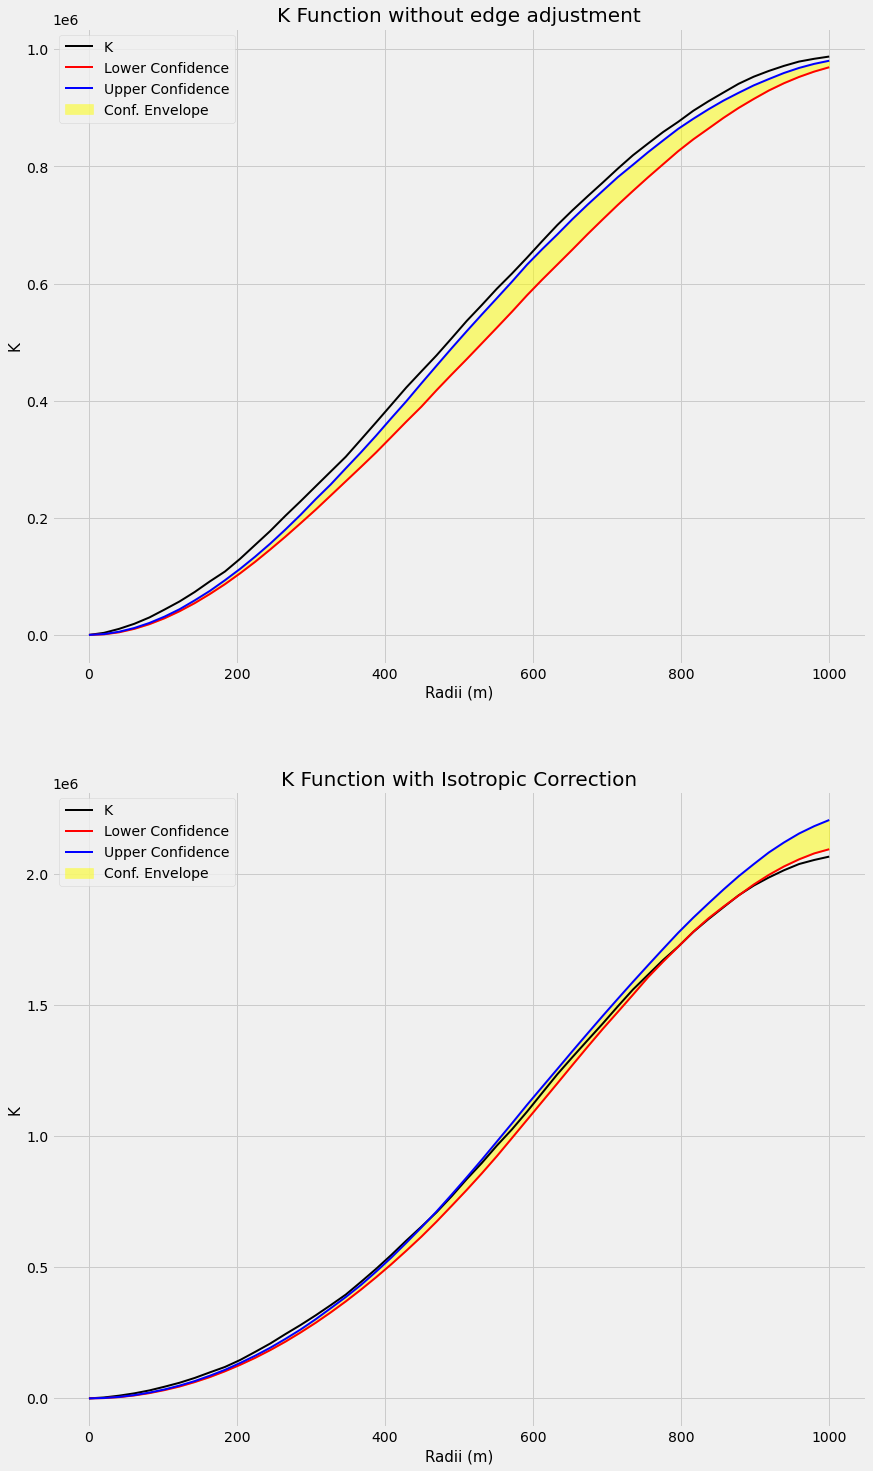

In [11]:
fig, [fig1,fig2] = plt.subplots(2,1,figsize=(13,24))

fig1.plot(radii,n_ripley,color='black',linewidth=2,label='K')
fig1.plot(radii,n_k10,color='red',linewidth=2,label='Lower Confidence')
fig1.plot(radii,n_k90,color='blue',linewidth=2,label='Upper Confidence')
fig1.fill_between(radii[:,0],n_k10[:,0],n_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig1.set_title('K Function without edge adjustment',size=20)
fig1.set_xlabel('Radii (m)',size=15); fig1.set_ylabel('K',size=15)
fig1.legend();

fig2.plot(radii,ripley,color='black',linewidth=2,label='K')
fig2.plot(radii,k10,color='red',linewidth=2,label='Lower Confidence')
fig2.plot(radii,k90,color='blue',linewidth=2,label='Upper Confidence')
fig2.fill_between(radii[:,0],k10[:,0],k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig2.set_title("K Function with Isotropic Correction",size=20)
fig2.set_xlabel('Radii (m)',size=15); fig2.set_ylabel('K',size=15)
fig2.legend();

#### Plot the $L$ and $H$ transforms
The K function can also be processed in order to improve visualization. Using the $L$ and $H$ transform functions provided previously, we obtain:

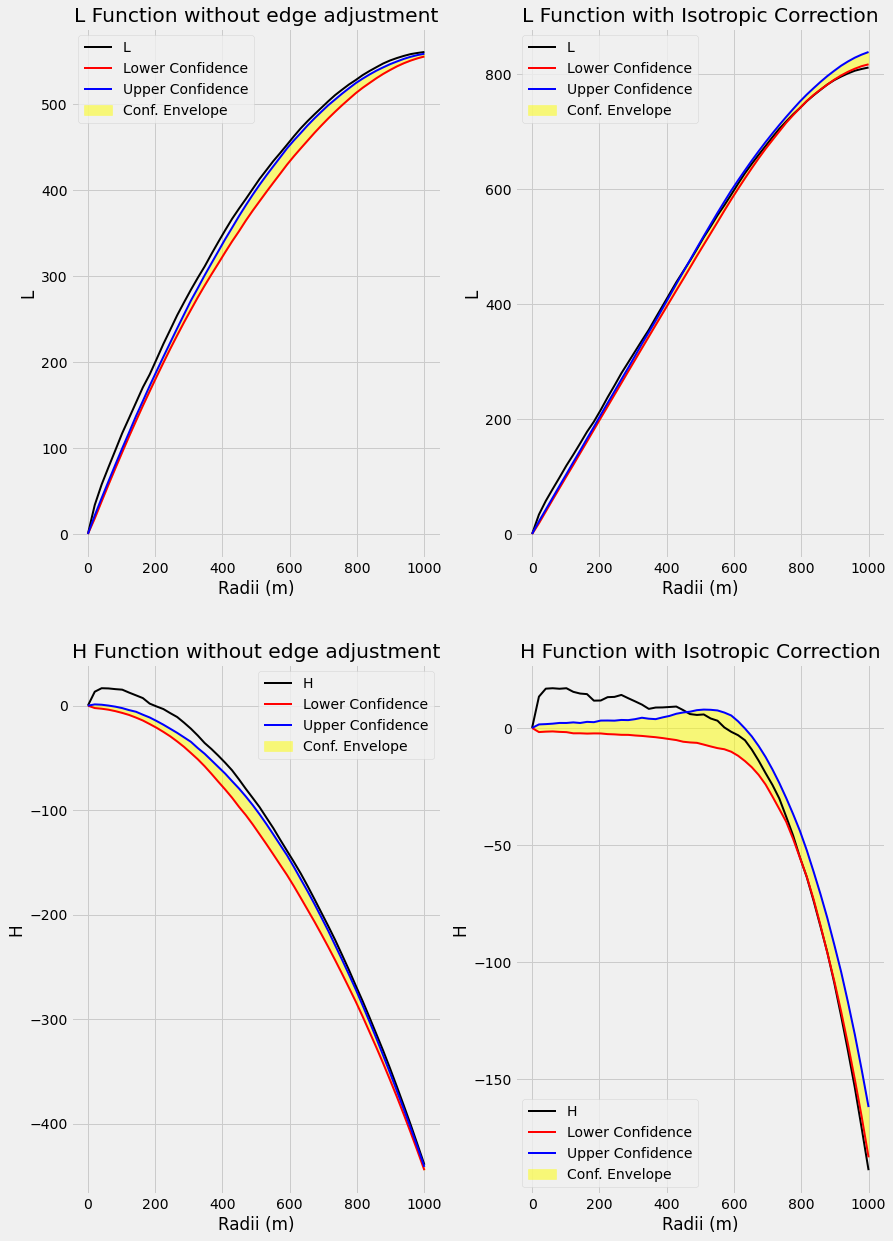

In [12]:
L_none = np.sqrt(n_ripley/np.pi)                                              # L without edge adjustment
L_none_k10 = np.sqrt(n_k10/np.pi); L_none_k90 = np.sqrt(n_k90/np.pi)          # L conf. env. without edge adjustment
L_ripley = np.sqrt(ripley/np.pi)                                              # L with isotropic correction
L_ripley_k10 = np.sqrt(k10/np.pi); L_ripley_k90 = np.sqrt(k90/np.pi)          # L conf. env. with isotropic correction

H_none = L_none - radii[:,0]                                                  # H without edge adjustment
H_none_k10 = L_none_k10 - radii; H_none_k90 = L_none_k90 - radii              # H conf. env. without edge adjustment
H_ripley = L_ripley - radii[:,0]                                              # H with isotropic correction
H_ripley_k10 = L_ripley_k10 - radii; H_ripley_k90 = L_ripley_k90 - radii      # H conf. env. with isotropic correction

plt.style.use('fivethirtyeight')
fig, [[fig1,fig2],[fig3,fig4]] = plt.subplots(2,2,figsize=(13,20))

fig1.plot(radii,L_none,color='black',linewidth=2,label='L')                   # L without edge adjustment plot settings
fig1.plot(radii,L_none_k10,color='red',linewidth=2,label='Lower Confidence')
fig1.plot(radii,L_none_k90,color='blue',linewidth=2,label='Upper Confidence')
fig1.fill_between(radii[:,0],L_none_k10[:,0],L_none_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig1.set_title('L Function without edge adjustment')
fig1.set_xlabel('Radii (m)'); fig1.set_ylabel('L')
fig1.legend();

fig2.plot(radii,L_ripley,color='black',linewidth=2,label='L')                 # L with isotropic correction plot settings
fig2.plot(radii,L_ripley_k10,color='red',linewidth=2,label='Lower Confidence')
fig2.plot(radii,L_ripley_k90,color='blue',linewidth=2,label='Upper Confidence')
fig2.fill_between(radii[:,0],L_ripley_k10[:,0],L_ripley_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig2.set_title("L Function with Isotropic Correction")
fig2.set_xlabel('Radii (m)'); fig2.set_ylabel('L')
fig2.legend();

fig3.plot(radii,H_none,color='black',linewidth=2,label='H')                   # H without edge adjustment plot settings 
fig3.plot(radii,H_none_k10,color='red',linewidth=2,label='Lower Confidence')
fig3.plot(radii,H_none_k90,color='blue',linewidth=2,label='Upper Confidence')
fig3.fill_between(radii[:,0],H_none_k10[:,0],H_none_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig3.set_title('H Function without edge adjustment')
fig3.set_xlabel('Radii (m)'); fig3.set_ylabel('H')
fig3.legend();

fig4.plot(radii,H_ripley,color='black',linewidth=2,label='H')                # H with isotropic correction plot settings
fig4.plot(radii,H_ripley_k10,color='red',linewidth=2,label='Lower Confidence')
fig4.plot(radii,H_ripley_k90,color='blue',linewidth=2,label='Upper Confidence')
fig4.fill_between(radii[:,0],H_ripley_k10[:,0],H_ripley_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig4.set_title("H Function with Isotropic Correction")
fig4.set_xlabel('Radii (m)'); fig4.set_ylabel('H')
fig4.legend();

The $H$ functions provide the best visualization of the regular Ripley K for this subsurface sample. Both the uncorrected and edge adjusted plots suggest siginificant event clustering for search radii less than or equal to $400 m$. For larger search radii, the edge correction approach factors in (because variance is greater for larger search radii) and while the no edge correction model suggests typical CSR behavior, the isotropically-corrected model indicates some event inhibition. Note that the uncorrected Ripley K curves (especially the confidence envelopes) are "smoother" because they tend to follow the theoretical K curve of a Poisson distribution. 

***
### Cross Ripley K
Even though the regular Ripley K function is a powerful statistic to describe the density of events in a SPP, it is often the case where events inside $A$ have distinct properties. In subsurface analysis, it is useful to know, for instance, if events of low permeability cluster or disperse about events of high permeability. Therefore, the cross Ripley K function operates exactly like the regular K but also considers different types of events contained by $A$. 

#### Distinguish events
Let us filter the events in *sample1* by their permeabilities. First, we will import the dataset again and obtain summary statistics of the events' permeabilities:

In [13]:
sample1 = read_csv('sample_data_biased_1.csv', usecols = ['X','Y','Perm'])
sample1['Perm'].describe()

count     279.000000
mean      212.546761
std       568.481338
min         0.075819
25%         3.666729
50%        14.908970
75%        64.608670
max      5308.842566
Name: Perm, dtype: float64

Now, let us convert this dataframe to NumPy arrays and filter the events for high and low permeability. We will place the high permeability events in matrix called *high_perm* and the events with low permeability in another matrix called *low_perm*:

In [14]:
sample1 = sample1.to_numpy()

low_perm_thresh = 20                                                     # Low threshold (20 mD)
high_perm_thresh = 70                                                    # High threshold (70 mD)

high_perm = np.zeros(shape=(1,2))
low_perm = np.zeros(shape=(1,2))

for i in range(len(sample1)):                                            # Filter by row (by event) and store coordinates
    if sample1[i,-1] <= low_perm_thresh:
        low_perm = np.row_stack((low_perm,sample1[i,0:-1]))
    elif sample1[i,-1] >= high_perm_thresh:
        high_perm = np.row_stack((high_perm,sample1[i,0:-1]))
        
high_perm = high_perm[1:]; low_perm = low_perm[1:]                       # Eliminate zero rows (from preallocating high_perm and low_perm)

print('Number of events with low permeability is:', len(low_perm))
print('Number of events with high permeability is:', len(high_perm))

Number of events with low permeability is: 162
Number of events with high permeability is: 69


Finally, let us create a scatter plot of the filtered data that will help us to validate our cross Ripley K graphic results:

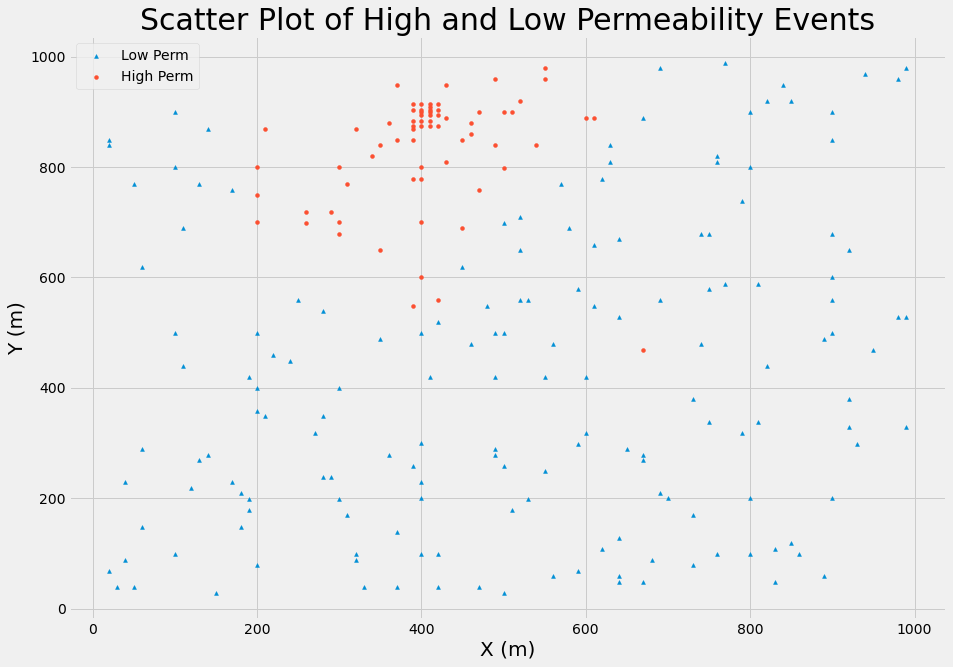

In [15]:
plt.figure(figsize=(14,10))
plt.title('Scatter Plot of High and Low Permeability Events',size=30)
plt.xlabel('X (m)',size=20); plt.ylabel('Y (m)',size=20)
plt.scatter(low_perm[:,0],low_perm[:,1],marker='^',s=15,label='Low Perm')
plt.scatter(high_perm[:,0],high_perm[:,1],marker='o',s=15,label='High Perm')
plt.legend()
plt.show()

We can see a clear cluster of high permeability events on $x = [200 m, 600 m]$ and $y = [600 m, 1000 m]$. Therefore, we can hypothesize that the cross $K$ function will initially indicate strong dispersion of low permeability events from the high permeablity events and then clustering for larger search radii.

#### Determine area of study and calculate search radii
Because we are using the same dataset *sample1* from before, the area of study $A$ and the search radii are the same from the previous regular K exercise.

#### Compute pairwise differences
We will use the same procedure of breaking up the distances between two events in $x$ and $y$ coordinates. However, because cross Ripley K accounts for different types of events, the dimensions of the *diff* matrix are different. For instance, consider the following example:

<img src="Ripley_K_Demo_3.png"/>

So if we decide to compute the cross Ripley K of the circle events relative to the star events, the only relevant distances are those between a star and a circle. Then, the number of relevant distances (i.e. the number of rows of *diff*) is given by:

<br>
\begin{equation}
D = N_a * N_b
\end{equation}

where $N_a$ is the number of events of type $a$ (e.g . stars) and $N_b$ is the number of events of type $b$ (e.g. circles).

Then, the *diff* matrix for *sample1* concerning low and high permeability events can be computed by:

In [16]:
npts = len(low_perm)                                         # Number of events with low perm
cross_npts = len(high_perm)                                  # Number of events with high perm

diff = np.zeros(shape = (npts*cross_npts,2))                 # Decomposed distances matrix

for i in range(cross_npts):             
    sub_data = np.zeros(shape=(npts,2))
    sub_data[:] = high_perm[i]
    diff[npts*i:npts*(i+1)] = abs(sub_data - low_perm)

Including edge correction terms is also very important for cross Ripley K. As such, we will evaluate the cross K function twice for the dataset (without correction and with Ripley's Isotropic Correction) to compare results.

#### Evaluate cross Ripley K (without edge adjustment)
The procedure to obtain the cross Ripley K of datasets is nearly identical to that of regular K functions. Without an edge correction approach, the only noticeable difference is in the intensity term. For instance, when calculating the cross K of low permeability events relative to high permeability events, the intensity is the quotient of the number of distances between high and low permeability events (not all possible distances) and the area of study $A$. Then:

In [17]:
n_ripley = np.zeros(len(radii))

distances = np.hypot(diff[:,0], diff[:,1])                                       # Pythagorean theorem

for r in range(len(radii)):
    n_ripley[r] = (distances<radii[r]).sum()
    
n_ripley = area * n_ripley / (npts * cross_npts)

#### Evaluate cross Ripley K (with Ripley's Isotropic Correction)
Similar to the evaluation without edge adjustment, the calculation of the cross K with isotropic correction features few changes from its regular procedure. The main modifications are in the for-loop which calculates the distances of select events to the border and in the intensity of the select events. So, the number of rows of *min_hor_dist* and *min_ver_dist* is equivalent to $npts*cross_{npts}$, and the intensity $\lambda$ equals $(npts*cross_{npts})/A$.

In [18]:
ripley = np.zeros(len(radii))

hor_dist = np.zeros(shape=(npts*cross_npts), dtype=np.double)
ver_dist = np.zeros(shape=(npts*cross_npts), dtype=np.double)

for k in range(cross_npts - 1):         # Finds horizontal and vertical distances from every high_perm event to nearest egde
    min_hor_dist = min(x_max - high_perm[k][0], high_perm[k][0] - x_min)
    min_ver_dist = min(y_max - high_perm[k][1], high_perm[k][1] - y_min)
    start = k*npts
    end = (k+1)*npts
    hor_dist[start: end] = min_hor_dist * np.ones(npts)
    ver_dist[start: end] = min_ver_dist * np.ones(npts)
    
dist = np.hypot(diff[:, 0], diff[:, 1])
dist_ind = dist <= np.hypot(hor_dist, ver_dist) # True if distance between events is less than or equal to distance to edge

w1 = (1 - (np.arccos(np.minimum(ver_dist, dist) / dist) + np.arccos(np.minimum(hor_dist, dist) / dist)) / np.pi)
w2 = (3 / 4 - 0.5 * (np.arccos(ver_dist / dist * ~dist_ind) + np.arccos(hor_dist / dist * ~dist_ind)) / np.pi)

weight = dist_ind * w1 + ~dist_ind * w2                                        # Weighting term

for r in range(len(radii)):
    ripley[r] = ((dist < radii[r]) / weight).sum()                             # Indicator function with summation term

ripley = area * ripley / (npts * cross_npts)

#### Create confidence envelope
Again, the process to create a confidence envelope is nearly identical to that of regular K confidence envelopes. However, note that the Monte Carlo simulations need to create $x$ and $y$ coordinates for both sets of events (e.g. for low and high permeability events). We will use the *ripley_K* function again for conciseness. First, the confidence envelope without edge correction:

In [19]:
Ks = np.zeros(shape=(len(radii),100))
xDel = x_max - x_min; yDel = y_max - y_min
edge = np.array([[0,0],[0,1000],[1000,1000],[1000,0]])                         # Boundary coordinates

for i in range(100):                                                           # 100 realizations
    x_coords = xDel*sts.uniform.rvs(0,1,((npts,1))) + x_min
    y_coords = yDel*sts.uniform.rvs(0,1,((npts,1))) + y_min
    cross_x_coords = xDel*sts.uniform.rvs(0,1,((cross_npts,1))) + x_min
    cross_y_coords = yDel*sts.uniform.rvs(0,1,((cross_npts,1))) + y_min
    
    Ks[:,i] = ripley_K(data_x=x_coords, data_y=y_coords, edge_x=edge[:,0],\
                       edge_y=edge[:,1], cross_data_x=cross_x_coords,\
                       cross_data_y=cross_y_coords, radii=radii, mode='none', cv=False)  # Compute Ripley K for pattern                              

n_k10 = np.zeros((len(radii),1))
n_k90 = np.zeros((len(radii),1))

for j in range(len(radii)):
    Ks[j,:] = np.sort(Ks[j,:])                                                 # Sort row of K values at fixed radius
    n_k10[j] = Ks[j,:][9]                                                      # Take P10 - lower fence
    n_k90[j] = Ks[j,:][89]                                                     # Take P90 - upper fence

And the confidence envelope with isotropic correction:

In [20]:
for i in range(100):                                                             # 100 realizations
    x_coords = xDel*sts.uniform.rvs(0,1,((npts,1))) + x_min
    y_coords = yDel*sts.uniform.rvs(0,1,((npts,1))) + y_min
    cross_x_coords = xDel*sts.uniform.rvs(0,1,((cross_npts,1))) + x_min
    cross_y_coords = yDel*sts.uniform.rvs(0,1,((cross_npts,1))) + y_min
    spp = np.column_stack((x_coords,y_coords))                                   # Assemble pattern coordinates
    cross_spp = np.column_stack((cross_x_coords,cross_y_coords))
    
    Ks[:,i] = ripley_K(data_x=x_coords, data_y=y_coords, edge_x=edge[:,0],\
                       edge_y=edge[:,1], cross_data_x=cross_x_coords,\
                       cross_data_y=cross_y_coords, radii=radii, mode='ripley', cv=False)  # Compute Ripley K for pattern                            

k10 = np.zeros((len(radii),1))
k90 = np.zeros((len(radii),1))

for j in range(len(radii)): 
    Ks[j,:] = np.sort(Ks[j,:])                                                   # Sort row of K values at fixed radius
    k10[j] = Ks[j,:][9]                                                          # Take P10 - lower fence
    k90[j] = Ks[j,:][89]                                                         # Take P90 - upper fence

#### Plot the cross Ripley K function
It is now time to plot the resulting cross Ripley K functions:

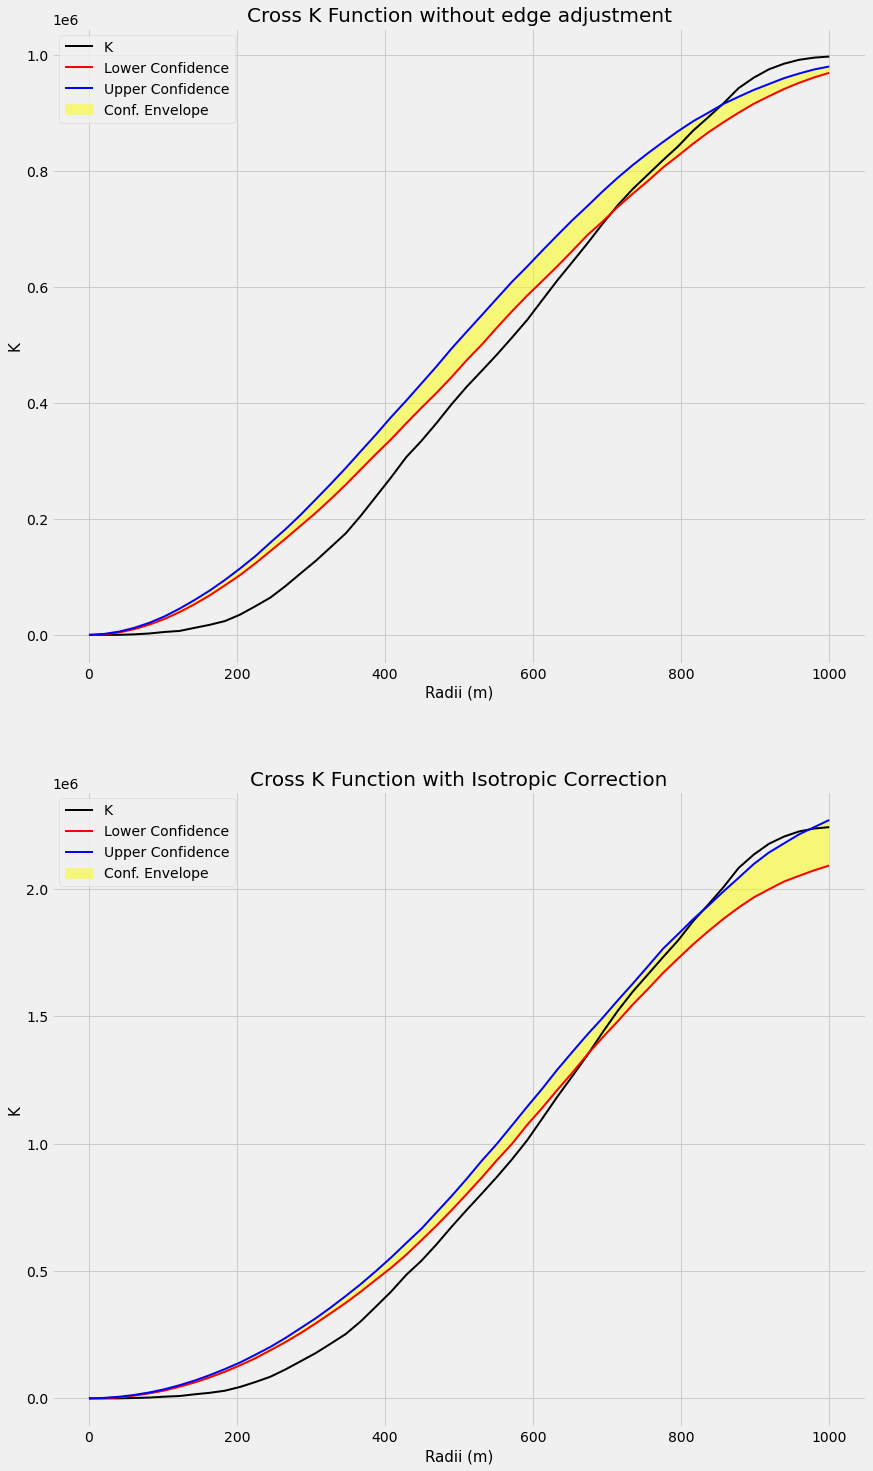

In [21]:
plt.style.use('fivethirtyeight')
fig, [fig1,fig2] = plt.subplots(2,1,figsize=(13,24))

fig1.plot(radii,n_ripley,color='black',linewidth=2,label='K')
fig1.plot(radii,n_k10,color='red',linewidth=2,label='Lower Confidence')
fig1.plot(radii,n_k90,color='blue',linewidth=2,label='Upper Confidence')
fig1.fill_between(radii[:,0],n_k10[:,0],n_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig1.set_title('Cross K Function without edge adjustment',size=20)
fig1.set_xlabel('Radii (m)',size=15); fig1.set_ylabel('K',size=15)
fig1.legend();

fig2.plot(radii,ripley,color='black',linewidth=2,label='K')
fig2.plot(radii,k10,color='red',linewidth=2,label='Lower Confidence')
fig2.plot(radii,k90,color='blue',linewidth=2,label='Upper Confidence')
fig2.fill_between(radii[:,0],k10[:,0],k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig2.set_title("Cross K Function with Isotropic Correction",size=20)
fig2.set_xlabel('Radii (m)',size=15); fig2.set_ylabel('K',size=15)
fig2.legend();

#### Plot the $L$ and $H$ transforms

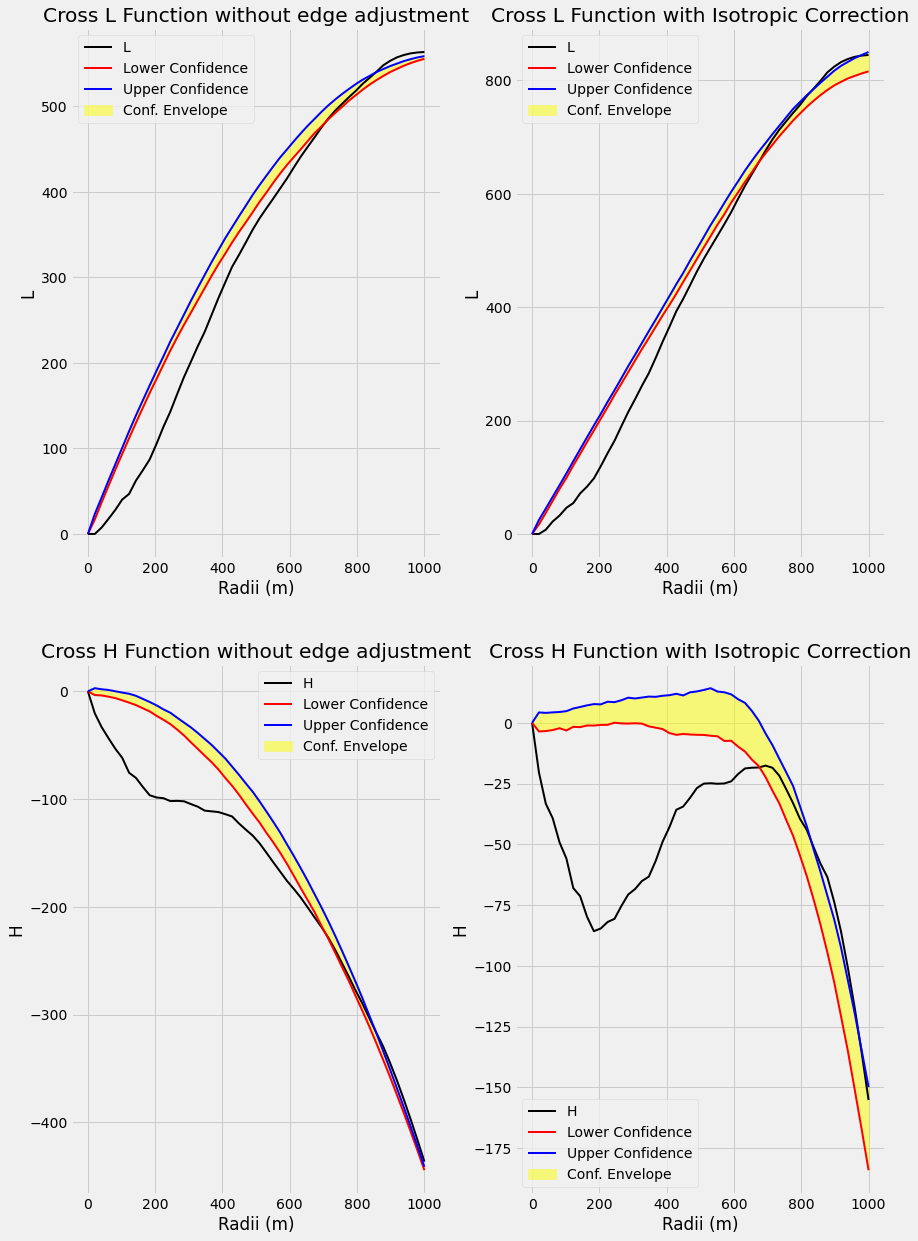

In [22]:
L_none = np.sqrt(n_ripley/np.pi)                                              # L without edge adjustment
L_none_k10 = np.sqrt(n_k10/np.pi); L_none_k90 = np.sqrt(n_k90/np.pi)          # L conf. env. without edge adjustment
L_ripley = np.sqrt(ripley/np.pi)                                              # L with isotropic correction
L_ripley_k10 = np.sqrt(k10/np.pi); L_ripley_k90 = np.sqrt(k90/np.pi)          # L conf. env. with isotropic correction

H_none = L_none - radii[:,0]                                                  # H without edge adjustment
H_none_k10 = L_none_k10 - radii; H_none_k90 = L_none_k90 - radii              # H conf. env. without edge adjustment
H_ripley = L_ripley - radii[:,0]                                              # H with isotropic correction
H_ripley_k10 = L_ripley_k10 - radii; H_ripley_k90 = L_ripley_k90 - radii      # H conf. env. with isotropic correction

plt.style.use('fivethirtyeight')
fig, [[fig1,fig2],[fig3,fig4]] = plt.subplots(2,2,figsize=(13,20))

fig1.plot(radii,L_none,color='black',linewidth=2,label='L')                   # L without edge adjustment plot settings
fig1.plot(radii,L_none_k10,color='red',linewidth=2,label='Lower Confidence')
fig1.plot(radii,L_none_k90,color='blue',linewidth=2,label='Upper Confidence')
fig1.fill_between(radii[:,0],L_none_k10[:,0],L_none_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig1.set_title('Cross L Function without edge adjustment')
fig1.set_xlabel('Radii (m)'); fig1.set_ylabel('L')
fig1.legend();

fig2.plot(radii,L_ripley,color='black',linewidth=2,label='L')                 # L with isotropic correction plot settings
fig2.plot(radii,L_ripley_k10,color='red',linewidth=2,label='Lower Confidence')
fig2.plot(radii,L_ripley_k90,color='blue',linewidth=2,label='Upper Confidence')
fig2.fill_between(radii[:,0],L_ripley_k10[:,0],L_ripley_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig2.set_title("Cross L Function with Isotropic Correction")
fig2.set_xlabel('Radii (m)'); fig2.set_ylabel('L')
fig2.legend();

fig3.plot(radii,H_none,color='black',linewidth=2,label='H')                   # H without edge adjustment plot settings 
fig3.plot(radii,H_none_k10,color='red',linewidth=2,label='Lower Confidence')
fig3.plot(radii,H_none_k90,color='blue',linewidth=2,label='Upper Confidence')
fig3.fill_between(radii[:,0],H_none_k10[:,0],H_none_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig3.set_title('Cross H Function without edge adjustment')
fig3.set_xlabel('Radii (m)'); fig3.set_ylabel('H')
fig3.legend();

fig4.plot(radii,H_ripley,color='black',linewidth=2,label='H')                # H with isotropic correction plot settings
fig4.plot(radii,H_ripley_k10,color='red',linewidth=2,label='Lower Confidence')
fig4.plot(radii,H_ripley_k90,color='blue',linewidth=2,label='Upper Confidence')
fig4.fill_between(radii[:,0],H_ripley_k10[:,0],H_ripley_k90[:,0],color='yellow',alpha=0.5,label='Conf. Envelope')
fig4.set_title("Cross H Function with Isotropic Correction")
fig4.set_xlabel('Radii (m)'); fig4.set_ylabel('H')
fig4.legend();

Again, the $H$ transforms provide the most detectable evidence that initially events of low permeability are more dispersed from events of high permeability and then more clustered than would be expected in a Poisson distribution. Recall that if the $K$ curve sits below the confidence envelope then there is dispersion, and if it sits above then there is clustering. Both the uncorrected and isotropically corrected functions suggest the most meaningful inhibition of low permeability events about high permeability events for search radii of $200 m$, but the isotropic correction shows the degree of dispersion with greater magnitude (i.e. $K$ curve dips further away from confidence envelope).

***
### *ripley_K* function
In order to generate confidence envelopes, this workflow relied on the *ripley_K* function. This Python utility synthesizes what this demonstration aims to show in a more efficient and functional format. *ripley_K* can be found on the GeostatsPy package and most of its code comes from the *class RipleysKEstimator* from the *AstroPy* package and from the *Kest* and *Kcross* functions in the **R** library *spatstat*. 

In [23]:
print(ripley_K.__doc__)

Calculates and plots regular or cross Ripley K curve for subsurface data. 
       Plots K curve with confidence envelopes defined by P25 and P975. Includes options for L or H transform functions.
       Regular Ripley K calculates the behavior of events defined by data_x and data_y about themselves.
       Cross Ripley K calculates the behavior of events defined by data_x and data_y about events
       defined by cross_data_x and cross_data_y.
    
    :param data_x: events x-coordinates
    :type: pandas.DataFrame
    :param data_y: events y-coordinates
    :type: pandas.DataFrame
    :param edge_x: boundary point x-coordinates
    :type: pandas.DataFrame
    :param edge_y: boundary point y-coordinates
    :type: pandas.DataFrame
    :param cross_data_x: default empty array for regular K; 
                         for cross K, pandas.DataFrame w/ x-coordinates of events from which to calculate K
    :param cross_data_y: default empty array for regular K; 
                         for 

***
### References
Find below some useful resources to learn more about the theory behind Ripley's K function, confidence envelopes, the AstroPy class utility which served as base code for the *ripley_K* function, and the *Kest* and *Kcross* functions in **R**:

1. [B.D.Ripley's original article on K function](https://www.jstor.org/stable/3212829?read-now=1&seq=1#page_scan_tab_contents)
2. [GeoDa tutorial - K function](https://www.youtube.com/watch?v=oT_jMTkkld8)
3. [Ripley K interactive](https://blog.jlevente.com/understanding-the-cross-k-function/)
4. [AstroPy - RipleysKEstimator](https://docs.astropy.org/en/stable/api/astropy.stats.RipleysKEstimator.html#astropy.stats.RipleysKEstimator.evaluate)
5. [Ripley's K theory and edge correction overview](https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=1048&context=stat_las_preprints)
6. [spatstat R documentation](https://cran.r-project.org/web/packages/spatstat/spatstat.pdf)
7. [Confidence envelopes](https://hpaulkeeler.com/poisson-point-process-simulation/)